# CS579: Assignment 1
<br>
-  In this assignment, we'll implement community detection and link prediction algorithms using Facebook "like" data.
<br><br>
-  The file `edges.txt.gz` indicates like relationships between facebook users. This was collected using snowball sampling: beginning with the user "Bill Gates", I crawled all the people he "likes", then, for each newly discovered user, I crawled all the people they liked.
<br><br>
-  We'll cluster the resulting graph into communities, as well as recommend friends for Bill Gates.
<br><br>
-  Complete the **15** methods below that are indicated by `TODO`. I've provided some sample output to help guide your implementation.


In [1]:
# You should not use any imports not listed here:
from collections import Counter, defaultdict, deque
import copy
from itertools import combinations
import math
import networkx as nx
import urllib.request

In [2]:
## Community Detection

def example_graph():
    """
    Create the example graph from class. Used for testing.
    Do not modify.
    """
    g = nx.Graph()
    g.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('D', 'E'), ('D', 'F'), ('D', 'G'), ('E', 'F'), ('G', 'F')])
    return g

In [3]:
graph = example_graph()
nx.draw(graph, with_labels=True)

/home/agericke/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [4]:
for node in graph.nodes:
    print(node)

A
B
C
D
E
F
G


In [5]:
dir(list)
a = sorted(('B', 'A'))
print(a)
a = tuple(a)
print(a)
dir(tuple)
#print(a.__hash__)

['A', 'B']
('A', 'B')


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

In [6]:
#dir(defaultdict)
node2distances = defaultdict(int)
node2distances['C'] = 1
help(node2distances.__contains__)
list(node2distances.items())
dir(list)

Help on built-in function __contains__:

__contains__(key, /) method of collections.defaultdict instance
    True if the dictionary has the specified key, else False.



['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [7]:
def bfs(graph, root, max_depth):
    """
    Perform breadth-first search to compute the shortest paths from a root node to all
    other nodes in the graph. To reduce running time, the max_depth parameter ends
    the search after the specified depth.
    E.g., if max_depth=2, only paths of length 2 or less will be considered.
    This means that nodes greather than max_depth distance from the root will not
    appear in the result.

    You may use these two classes to help with this implementation:
      https://docs.python.org/3.5/library/collections.html#collections.defaultdict
      https://docs.python.org/3.5/library/collections.html#collections.deque

    Params:
      graph.......A networkx Graph
      root........The root node in the search graph (a string). We are computing
                  shortest paths from this node to all others.
      max_depth...An integer representing the maximum depth to search.

    Returns:
      node2distances...dict from each node to the length of the shortest path from
                       the root node
      node2num_paths...dict from each node to the number of shortest paths from the
                       root node to this node.
      node2parents.....dict from each node to the list of its parents in the search
                       tree

    In the doctests below, we first try with max_depth=5, then max_depth=2.

    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 5)
    >>> sorted(node2distances.items())
    [('A', 3), ('B', 2), ('C', 3), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]
    >>> sorted(node2num_paths.items())
    [('A', 1), ('B', 1), ('C', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]
    >>> sorted((node, sorted(parents)) for node, parents in node2parents.items())
    [('A', ['B']), ('B', ['D']), ('C', ['B']), ('D', ['E']), ('F', ['E']), ('G', ['D', 'F'])]
    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 2)
    >>> sorted(node2distances.items())
    [('B', 2), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]
    >>> sorted(node2num_paths.items())
    [('B', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]
    >>> sorted((node, sorted(parents)) for node, parents in node2parents.items())
    [('B', ['D']), ('D', ['E']), ('F', ['E']), ('G', ['D', 'F'])]
    """
    q = deque()
    q.append(root)
    seen = set()       # nodes we have already visited.
    res = []
    depth = 1  # Track depth of the search
    node2distances = defaultdict(int)
    node2num_paths = defaultdict(int)
    node2parents = defaultdict(list)
    node2distances[root] = 0
    node2num_paths[root] = 1
    if max_depth == 0:
        return node2distances, node2num_paths, node2parents
    while len(q) > 0:  # while more to visit
        n = q.popleft()
        if n == 'null':
            depth += 1
            continue
        if depth > max_depth:
            return node2distances, node2num_paths, node2parents
        if n not in seen:
            res.append(n)
            seen.add(n)
        for nn in graph.neighbors(n):
            if nn not in seen:
                if not q.__contains__(nn):
                    q.append(nn)
                if not node2distances.__contains__(nn):
                    node2distances[nn] = depth
            if node2distances[nn] == (node2distances[n]+1):
                node2parents[nn].append(n)
                node2num_paths[nn] += 1 
        q.append('null')
        if n == root:
            depth += 1
    return node2distances, node2num_paths, node2parents

node2distances, node2num_paths, node2parents = bfs(graph, 'E', 5)
print(node2distances)
print(sorted(node2distances.items()))
print(sorted(node2num_paths.items()))
print(sorted((node, sorted(parents)) for node, parents in node2parents.items()))

defaultdict(<class 'int'>, {'E': 0, 'D': 1, 'F': 1, 'B': 2, 'G': 2, 'A': 3, 'C': 3})
[('A', 3), ('B', 2), ('C', 3), ('D', 1), ('E', 0), ('F', 1), ('G', 2)]
[('A', 1), ('B', 1), ('C', 1), ('D', 1), ('E', 1), ('F', 1), ('G', 2)]
[('A', ['B']), ('B', ['D']), ('C', ['B']), ('D', ['E']), ('F', ['E']), ('G', ['D', 'F'])]


In [8]:
node2distances_order = sorted(node2distances.items(), key=lambda x:(-x[1], x[0]))
#for k,v in node2distances_order:
    #print(k)
    #print(v)
    #print('\n')
    
result = defaultdict(float)
resulta = dict()
resulta['k'] = 'b'
list(resulta.items())
a = list([('A', 'B'), ('C', 'D')])
dir(list)
a.append(('G','Z'))
b = dict()
b[('A', 'B')] = 3
list(b.items())
#list(('a','b')).items()
node2distances_order = sorted(node2distances.items(), key=lambda x:(-x[1], x[0]))
keys_ = list(dict(node2distances_order).keys())

#q = deque()
if ('Z') not in node2distances.keys():
    print('cabron')
    
print(list(node2parents.items()))
if ('F') not in node2parents.values():
    print('cabron2')
    
    

cabron
[('D', ['E']), ('F', ['E']), ('B', ['D']), ('G', ['D', 'F']), ('A', ['B']), ('C', ['B'])]
cabron2


In [9]:
def bottom_up(root, node2distances, node2num_paths, node2parents):
    """
    Compute the final step of the Girvan-Newman algorithm.
    See p 352 From your text:
    https://github.com/iit-cs579/main/blob/master/read/lru-10.pdf
        The third and final step is to calculate for each edge e the sum
        over all nodes Y of the fraction of shortest paths from the root
        X to Y that go through e. This calculation involves computing this
        sum for both nodes and edges, from the bottom. Each node other
        than the root is given a credit of 1, representing the shortest
        path to that node. This credit may be divided among nodes and
        edges above, since there could be several different shortest paths
        to the node. The rules for the calculation are as follows: ...

    Params:
      root.............The root node in the search graph (a string). We are computing
                       shortest paths from this node to all others.
      node2distances...dict from each node to the length of the shortest path from
                       the root node
      node2num_paths...dict from each node to the number of shortest paths from the
                       root node that pass through this node.
      node2parents.....dict from each node to the list of its parents in the search
                       tree
    Returns:
      A dict mapping edges to credit value. Each key is a tuple of two strings
      representing an edge (e.g., ('A', 'B')). Make sure each of these tuples
      are sorted alphabetically (so, it's ('A', 'B'), not ('B', 'A')).

      Any edges excluded from the results in bfs should also be exluded here.

    >>> node2distances, node2num_paths, node2parents = bfs(example_graph(), 'E', 5)
    >>> result = bottom_up('E', node2distances, node2num_paths, node2parents)
    >>> sorted(result.items())
    [(('A', 'B'), 1.0), (('B', 'C'), 1.0), (('B', 'D'), 3.0), (('D', 'E'), 4.5), (('D', 'G'), 0.5), (('E', 'F'), 1.5), (('F', 'G'), 0.5)]
    """
    node_credit = defaultdict(float)
    edges_credit = defaultdict(float)
    
    node2distances_order = sorted(node2distances.items(), key=lambda x:(-x[1], x[0]))
    
    for node, depth in node2distances_order:
        node_credit[node] += 1
        num_paths = node2num_paths[node]
        for parents in node2parents[node]:
            for parent in parents:
                edge = sorted((node, parent))
                edges_credit[tuple(sorted((node, parent)))] += node_credit[node]/num_paths
                node_credit[parent] += node_credit[node]/num_paths
    return edges_credit

result = bottom_up('F', node2distances, node2num_paths, node2parents)
sorted(result.items())

[(('A', 'B'), 1.0),
 (('B', 'C'), 1.0),
 (('B', 'D'), 3.0),
 (('D', 'E'), 4.5),
 (('D', 'G'), 0.5),
 (('E', 'F'), 1.5),
 (('F', 'G'), 0.5)]

In [10]:
c = dict(a=1.5,b=3.5)
print(c)
a = Counter(c)
print(a)
for k,v in a.items():
    a[k] /= 2
print(a)

{'a': 1.5, 'b': 3.5}
Counter({'b': 3.5, 'a': 1.5})
Counter({'b': 1.75, 'a': 0.75})


In [11]:
def approximate_betweenness(graph, max_depth):
    """
    Compute the approximate betweenness of each edge, using max_depth to reduce
    computation time in breadth-first search.

    You should call the bfs and bottom_up functions defined above for each node
    in the graph, and sum together the results. Be sure to divide by 2 at the
    end to get the final betweenness.

    Params:
      graph.......A networkx Graph
      max_depth...An integer representing the maximum depth to search.

    Returns:
      A dict mapping edges to betweenness. Each key is a tuple of two strings
      representing an edge (e.g., ('A', 'B')). Make sure each of these tuples
      are sorted alphabetically (so, it's ('A', 'B'), not ('B', 'A')).

    >>> sorted(approximate_betweenness(example_graph(), 2).items())
    [(('A', 'B'), 2.0), (('A', 'C'), 1.0), (('B', 'C'), 2.0), (('B', 'D'), 6.0), (('D', 'E'), 2.5), (('D', 'F'), 2.0), (('D', 'G'), 2.5), (('E', 'F'), 1.5), (('F', 'G'), 1.5)]
    """
    edges_btw = Counter()
    for node in graph.nodes():
        node2distances, node2num_paths, node2parents = bfs(graph, node, max_depth)
        edges_credit = bottom_up(node, node2distances, node2num_paths, node2parents)
        edges_btw.update(edges_credit)
    edges_btw = dict(edges_btw)
    for k,v in edges_btw.items():
        edges_btw[k] /= 2
    return edges_btw
        
print(sorted(approximate_betweenness(example_graph(), 2).items()))
print('\n')
print(sorted(approximate_betweenness(example_graph(), 2).items(), key=lambda x:x[1], reverse=True)[0][0])

[(('A', 'B'), 2.0), (('A', 'C'), 1.0), (('B', 'C'), 2.0), (('B', 'D'), 6.0), (('D', 'E'), 2.5), (('D', 'F'), 2.0), (('D', 'G'), 2.5), (('E', 'F'), 1.5), (('F', 'G'), 1.5)]


('B', 'D')


In [12]:
def get_components(graph):
    """
    A helper function you may use below.
    Returns the list of all connected components in the given graph.
    """
    return [c for c in nx.connected_component_subgraphs(graph)]

In [13]:
def partition_girvan_newman(graph, max_depth):
    """
    Use your approximate_betweenness implementation to partition a graph.
    Unlike in class, here you will not implement this recursively. Instead,
    just remove edges until more than one component is created, then return
    those components.
    That is, compute the approximate betweenness of all edges, and remove
    them until multiple components are created.

    You only need to compute the betweenness once.
    If there are ties in edge betweenness, break by edge name (e.g.,
    (('A', 'B'), 1.0) comes before (('B', 'C'), 1.0)).

    Note: the original graph variable should not be modified. Instead,
    make a copy of the original graph prior to removing edges.
    See the Graph.copy method https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.copy.html
    Params:
      graph.......A networkx Graph
      max_depth...An integer representing the maximum depth to search.

    Returns:
      A list of networkx Graph objects, one per partition.

    >>> components = partition_girvan_newman(example_graph(), 5)
    >>> components = sorted(components, key=lambda x: sorted(x.nodes())[0])
    >>> sorted(components[0].nodes())
    ['A', 'B', 'C']
    >>> sorted(components[1].nodes())
    ['D', 'E', 'F', 'G']
    """
    graph_copy = graph.copy()
    while (len(get_components(graph_copy)) < 2):
        edge_to_remove = sorted(approximate_betweenness(graph_copy, max_depth).items(), key=lambda x:x[1], reverse=True)[0][0]
        graph_copy.remove_edge(*edge_to_remove)
    return list(get_components(graph_copy))

components = partition_girvan_newman(example_graph(), 4)
components = sorted(components, key=lambda x: sorted(x.nodes())[0])
print(components)
print(sorted(components[0].nodes()))
print(sorted(components[1].nodes()))

[<networkx.classes.graph.Graph object at 0x7facf5e85a58>, <networkx.classes.graph.Graph object at 0x7facf5e85898>]
['A', 'B', 'C']
['D', 'E', 'F', 'G']


{'A': 2, 'B': 3, 'C': 2, 'D': 4, 'E': 2, 'F': 3, 'G': 2}
dict_items([('A', 2), ('B', 3), ('C', 2), ('D', 4), ('E', 2), ('F', 3), ('G', 2)])


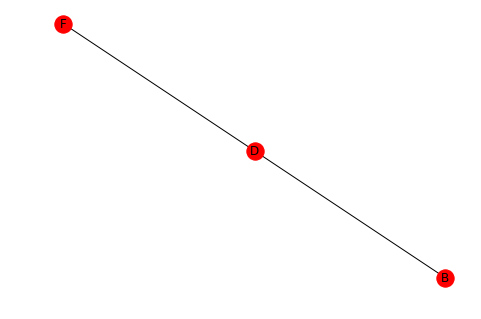

In [14]:
degrees = dict(graph.degree())
print(degrees)
min_degree = 3
nodes_subgraph = set()
print(degrees.items())
for node, degree in degrees.items():
    if degree >= min_degree:
        nodes_subgraph.update(node)
subgraph_example = graph.subgraph(nodes_subgraph)
nx.draw(subgraph_example, with_labels=True)
        


In [15]:
def get_subgraph(graph, min_degree):
    """Return a subgraph containing nodes whose degree is
    greater than or equal to min_degree.
    We'll use this in the main method to prune the original graph.

    Params:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.

    >>> subgraph = get_subgraph(example_graph(), 3)
    >>> sorted(subgraph.nodes())
    ['B', 'D', 'F']
    >>> len(subgraph.edges())
    2
    """
    degrees = dict(graph.degree())
    nodes_subgraph = set()
    for node, degree in degrees.items():
        if degree >= min_degree:
            nodes_subgraph.update(node)
    return graph.subgraph(nodes_subgraph)

subgraph = get_subgraph(example_graph(), 3)
print(sorted(subgraph.nodes()))
#    ['B', 'D', 'F']
len(subgraph.edges())

['B', 'D', 'F']


2

In [16]:
#dir(graph)
#print(sorted(graph.degree, key=lambda x: x[1], reverse=True))
type(get_subgraph(example_graph(), 3))
subgraph = get_subgraph(graph, 1)
degrees = dict(graph.degree())
#print(degrees)
nodes_subgraph = set()
for node, degree in degrees.items():
        if degree >= 35:
            nodes_subgraph.update(node)
#print(nodes_subgraph)
mierda = graph.subgraph(nodes_subgraph)
mierda.nodes()
#print('subgraph has %d nodes and %d edges' %
 #     (len(subgraph.nodes()), subgraph.number_of_edges()))


NodeView(())

In [17]:
def volume(nodes, graph):
    """
    Compute the volume for a list of nodes, which
    is the number of edges in `graph` with at least one end in
    nodes.
    Params:
      nodes...a list of strings for the nodes to compute the volume of.
      graph...a networkx graph

    >>> volume(['A', 'B', 'C'], example_graph())
    4
    """
    ext_edges = 0
    int_edges = 0
    for node in nodes:
        for neighbor in graph.neighbors(node):
            if neighbor not in nodes:
                ext_edges += 1
            else:
                int_edges +=1
    return round(int_edges/2 + ext_edges)
volume(['D', 'E', 'F', 'G'], example_graph())

6

In [18]:
def cut(S, T, graph):
    """
    Compute the cut-set of the cut (S,T), which is
    the set of edges that have one endpoint in S and
    the other in T.
    Params:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An int representing the cut-set.

    >>> cut(['A', 'B', 'C'], ['D', 'E', 'F', 'G'], example_graph())
    1
    """
    cut_set = 0
    for node in S:
        for neighbor in graph.neighbors(node):
            if neighbor in T:
                cut_set += 1
    return cut_set
                
cut(['A', 'B', 'C', 'D', 'E', 'G'], ['F'], example_graph())

3

In [19]:
def norm_cut(S, T, graph):
    """
    The normalized cut value for the cut S/T. (See lec06.)
    Params:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An float representing the normalized cut value

    """
    return (cut(S, T, graph)*(1/volume(S, graph) + 1/volume(T, graph)))
norm_cut(['A', 'B', 'C', 'D', 'E', 'G'], ['F'], graph)

1.3333333333333333

In [20]:
b = nx.boundary_expansion(graph, ['D'])
b

4.0

In [21]:
help(nx.cuts)
#b = list(nx.(graph, 3))
#print(b)#print(graph.edges())

Help on module networkx.algorithms.cuts in networkx.algorithms:

NAME
    networkx.algorithms.cuts - Functions for finding and evaluating cuts in a graph.

FUNCTIONS
    boundary_expansion(G, S)
        Returns the boundary expansion of the set `S`.
        
        The *boundary expansion* is the quotient of the size of the edge
        boundary and the cardinality of *S*. [1]
        
        Parameters
        ----------
        G : NetworkX graph
        
        S : sequence
            A sequence of nodes in `G`.
        
        Returns
        -------
        number
            The boundary expansion of the set `S`.
        
        See also
        --------
        edge_expansion
        mixing_expansion
        node_expansion
        
        References
        ----------
        .. [1] Vadhan, Salil P.
               "Pseudorandomness."
               *Foundations and Trends in Theoretical Computer Science*
               7.1–3 (2011): 1–336.
               <https://doi.org/

In [22]:
dir(nx)
depths = list(range(1,5))
type(depths)
depths

[1, 2, 3, 4]

In [23]:
def brute_force_norm_cut(graph, max_size):
    """
    Enumerate over all possible cuts of the graph, up to max_size, and compute the norm cut score.
    Params:
        graph......graph to be partitioned
        max_size...maximum number of edges to consider for each cut.
                   E.g, if max_size=2, consider removing edge sets
                   of size 1 or 2 edges.
    Returns:
        (unsorted) list of (score, edge_list) tuples, where
        score is the norm_cut score for each cut, and edge_list
        is the list of edges (source, target) for each cut.
        

    Note: only return entries if removing the edges results in exactly
    two connected components.

    You may find itertools.combinations useful here.

    >>> r = brute_force_norm_cut(example_graph(), 1)
    >>> len(r)
    1
    >>> r
    [(0.41666666666666663, [('B', 'D')])]
    >>> r = brute_force_norm_cut(example_graph(), 2)
    >>> len(r)
    14
    >>> sorted(r)[0]
    (0.41666666666666663, [('A', 'B'), ('B', 'D')])
    """
    ###TODO
    pass

In [24]:
def score_max_depths(graph, max_depths):
    """
    In order to assess the quality of the approximate partitioning method
    we've developed, we will run it with different values for max_depth
    and see how it affects the norm_cut score of the resulting partitions.
    Recall that smaller norm_cut scores correspond to better partitions.

    Params:
      graph........a networkx Graph
      max_depths...a list of ints for the max_depth values to be passed
                   to calls to partition_girvan_newman

    Returns:
      A list of (int, float) tuples representing the max_depth and the
      norm_cut value obtained by the partitions returned by
      partition_girvan_newman. See Log.txt for an example.
    """
    result = defaultdict(float)
    for i in max_depths:
        components = partition_girvan_newman(graph, i)
        norm_cut_val = norm_cut(sorted(components[0].nodes()), sorted(components[1].nodes()), graph)
        result[i] = norm_cut_val
    return sorted(result.items())

depths = list(range(1,5))
result = score_max_depths(example_graph(), depths)
print(result)
        

[(1, 1.2222222222222223), (2, 0.41666666666666663), (3, 0.41666666666666663), (4, 0.41666666666666663)]


In [25]:
graph = example_graph()
#type(graph)
#dir(graph)
#help(graph.neighbors)
sorted(graph.neighbors('A'))[2]

IndexError: list index out of range

In [26]:
## Link prediction

# Next, we'll consider the link prediction problem. In particular,
# we will remove 5 of the accounts that Bill Gates likes and
# compute our accuracy at recovering those links.

def make_training_graph(graph, test_node, n):
    """
    To make a training graph, we need to remove n edges from the graph.
    As in lecture, we'll assume there is a test_node for which we will
    remove some edges. Remove the edges to the first n neighbors of
    test_node, where the neighbors are sorted alphabetically.
    E.g., if 'A' has neighbors 'B' and 'C', and n=1, then the edge
    ('A', 'B') will be removed.

    Be sure to *copy* the input graph prior to removing edges.

    Params:
      graph.......a networkx Graph
      test_node...a string representing one node in the graph whose
                  edges will be removed.
      n...........the number of edges to remove.

    Returns:
      A *new* networkx Graph with n edges removed.

    In this doctest, we remove edges for two friends of D:
    >>> g = example_graph()
    >>> sorted(g.neighbors('D'))
    ['B', 'E', 'F', 'G']
    >>> train_graph = make_training_graph(g, 'D', 2)
    >>> sorted(train_graph.neighbors('D'))
    ['F', 'G']
    """
    graph_copy = graph.copy()
    neighbors = sorted(graph_copy.neighbors(test_node))
    remove_edges = 0
    while (remove_edges < n and remove_edges < len(neighbors)):
        graph_copy.remove_edge(test_node, neighbors[remove_edges])
        remove_edges += 1
    return graph_copy

g = example_graph()
print(sorted(g.neighbors('B')))
#['B', 'E', 'F', 'G']
train_graph = make_training_graph(g, 'B', 4)
print(sorted(train_graph.neighbors('B')))

['A', 'C', 'D']
[]


In [27]:
def jaccard(graph, node, k):
    """
    Compute the k highest scoring edges to add to this node based on
    the Jaccard similarity measure.
    Note that we don't return scores for edges that already appear in the graph.

    Params:
      graph....a networkx graph
      node.....a node in the graph (a string) to recommend links for.
      k........the number of links to recommend.

    Returns:
      A list of tuples in descending order of score representing the
      recommended new edges. Ties are broken by
      alphabetical order of the terminal node in the edge.

    In this example below, we remove edges (D, B) and (D, E) from the
    example graph. The top two edges to add according to Jaccard are
    (D, E), with score 0.5, and (D, A), with score 0. (Note that all the
    other remaining edges have score 0, but 'A' is first alphabetically.)

    >>> g = example_graph()
    >>> train_graph = make_training_graph(g, 'D', 2)
    >>> jaccard(train_graph, 'D', 2)
    [(('D', 'E'), 0.5), (('D', 'A'), 0.0)]
    """
    new_edges = defaultdict(float)
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        if (graph.has_edge(node, n) or node==n):
            continue
        neighbors2 = set(graph.neighbors(n))
        new_edges[tuple((node, n))] = len(neighbors & neighbors2) / len(neighbors | neighbors2)
        #print(new_edges)
    return sorted(new_edges.items(), key=lambda x: (-x[1], x[0][1]))[:k]

g = example_graph()
train_graph = make_training_graph(g, 'D', 2)
jaccard(train_graph, 'D', 2)
#    [(('D', 'E'), 0.5), (('D', 'A'), 0.0)]

[(('D', 'E'), 0.5), (('D', 'A'), 0.0)]

In [29]:
help(graph.has_edge)

Help on method has_edge in module networkx.classes.graph:

has_edge(u, v) method of networkx.classes.graph.Graph instance
    Return True if the edge (u, v) is in the graph.
    
    This is the same as `v in G[u]` without KeyError exceptions.
    
    Parameters
    ----------
    u, v : nodes
        Nodes can be, for example, strings or numbers.
        Nodes must be hashable (and not None) Python objects.
    
    Returns
    -------
    edge_ind : bool
        True if edge is in the graph, False otherwise.
    
    Examples
    --------
    >>> G = nx.path_graph(4)  # or DiGraph, MultiGraph, MultiDiGraph, etc
    >>> G.has_edge(0, 1)  # using two nodes
    True
    >>> e = (0, 1)
    >>> G.has_edge(*e)  #  e is a 2-tuple (u, v)
    True
    >>> e = (0, 1, {'weight':7})
    >>> G.has_edge(*e[:2])  # e is a 3-tuple (u, v, data_dictionary)
    True
    
    The following syntax are equivalent:
    
    >>> G.has_edge(0, 1)
    True
    >>> 1 in G[0]  # though this gives KeyError if 0

In [39]:
def evaluate(predicted_edges, graph):
    """
    Return the fraction of the predicted edges that exist in the graph.

    Args:
      predicted_edges...a list of edges (tuples) that are predicted to
                        exist in this graph
      graph.............a networkx Graph

    Returns:
      The fraction of edges in predicted_edges that exist in the graph.

    In this doctest, the edge ('D', 'E') appears in the example_graph,
    but ('D', 'A') does not, so 1/2 = 0.5

    >>> evaluate([('D', 'E'), ('D', 'A')], example_graph())
    0.5
    """
    exist = 0
    if (len(predicted_edges) == 0):
        return print("Error. You must provide a non-empty list of edges")
    for edge in predicted_edges:
        if (graph.has_edge(*edge)):
            exist += 1
    return (exist/len(predicted_edges))

print(evaluate([('D', 'E'), ('D', 'A'), ('D', 'B'), ('B', 'B'), ('Z', 'B')], example_graph()))
evaluate([], example_graph())

0.4
Error. You must provide a non-empty list of edges
